# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [6]:
import import_ipynb
os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [7]:
def TLfilter(stimulus, tau_y, dt):
    if tau_y == 0: return stimulus
    T = np.arange(0,int(tau_y/dt*8))*dt
    Ky=T/tau_y**2 *np.exp(-T/tau_y)
    sstm = np.zeros_like(stimulus)
    plt.plot(T,Ky, label = str(T[Ky ==max(Ky)]))
    plt.legend()
    for i in range(len(Ky)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*Ky[i-ii]*dt
    sx = np.convolve(stimulus,Ky,'valid')*dt
    sstm[len(Ky)-1:] = sx.copy()
    return sstm

# chose file

In [15]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
# Fc = 8
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')

Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
dt = 0.01
x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][53-1,:]

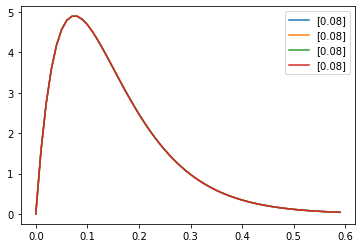

In [16]:
dt = 0.01
sampling_rate = 20000
v_list = []
tv_list = []
s_list = []
t_cor_list = []
Dt = 0.01
for i in range(len(x_list)):
    x = x_list[i].copy()
    tv_list.append( np.append(0, np.diff(x)) / dt)
    v = np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)]) / Dt
    v_list.append( v)
    
    s_list.append(TLfilter(x, 0.075, dt))
    x_list.append(x.copy())
    v_list.append(v.copy())
    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt*3/2)
    t_cor_list.append(np.interp(0.5*max(x_cor),  x_cor, Taxis))

In [17]:
t_cor_list

[0.5141158203537964,
 0.4122846678783801,
 0.3854199641047879,
 0.37514798623074574]

# for $\beta$

In [193]:
# Lambdas =  np.arange(0.1,0.91,0.1)
Lambdas =  np.array([0.533])
betas = (1-Lambdas)/Lambdas
alpha = 20. #1/sec
K = 23.
g = 40.
phi = 1.

In [194]:
##response
# Model one: simple estimation
window = [-1,1] # second
Information_list = [0]*len(annots_list)
ngd_Information_list = [0]*len(annots_list)
realInformation_list = [0]*len(annots_list)
y_list = [0]*len(annots_list)
r_list = [0]*len(annots_list)
for i in range(len(annots_list)):
    x = x_list[i]
    v = v_list[i]
    s = s_list[i]
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    Information_list[i] = [0]*len(Lambdas)
    realInformation_list[i] = [0]*len(Lambdas)
    ngd_Information_list[i] = [0]*len(Lambdas)
    y_list[i] = [0]*len(Lambdas)
    r_list[i] = [0]*len(Lambdas)
    for j in range(len(Lambdas)):
        Lambda = Lambdas[j]
        beta = betas[j]
        print(Fc_list[i], Lambda, beta)
        y=np.zeros(len(T_list[i]))
        z=np.zeros(len(T_list[i]))
        for k in range(len(T_list[i])-1):
            dy=dt*(-alpha*y[k]+K*(s[k]-phi*z[k]))
            dz=dt*(-beta*z[k]+g*y[k])
            y[k+1]=y[k]+dy
            z[k+1]=z[k]+dz
        y_list[i][j] = y.copy()
        r = NL(np.mean(y)-y, 0)
#         ratio = sum(r)/T_list[i][-1]/12
        ratio = sum(r)/282
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
        rstate = rstate.astype(int)

        #calculate information
        timeshift, ngd_Information_list[i][j] = PIfunc(rstate, xstate, vstate, dt, window)
        r1 = (1-Lambda)*s+Lambda*np.append(0,np.diff(s))/dt
        r_list[i][j] = r1.copy()
        r = NL(np.mean(r1)-r1, 0)
        ratio = sum(r)/T_list[i][-1]/1
#         ratio = sum(r)/600
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
        rstate = rstate.astype(int)
        #calculate information
        timeshift, Information_list[i][j] = PIfunc(rstate, xstate, vstate, dt, window)
        
        timeshift, realInformation_list[i][j] = PIfunc(rstate_list[i], xstate, vstate, dt, window)

2 0.533 0.8761726078799249


# For Paper 

Fc= 2


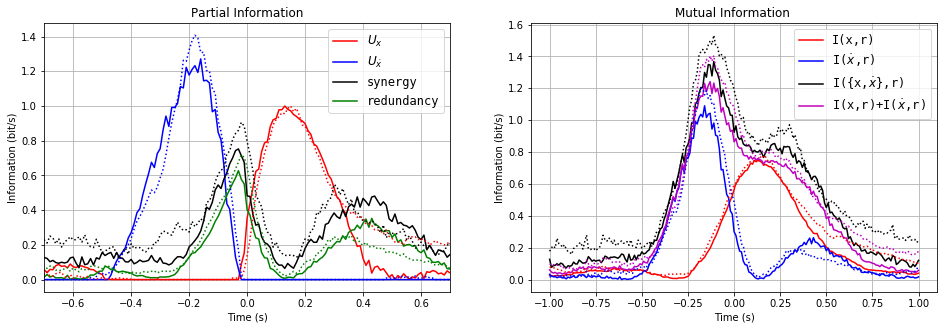

In [195]:
i = 0
print('Fc=', Fc_list[i])
processingtime = 0.0
for j in range(len(Lambdas)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift-processingtime,Information_list[i][j][('Beer','UIx')]/max(Information_list[i][j][('Beer','UIx')]), 'r-')
    ax2.plot(timeshift-processingtime,Information_list[i][j][('Beer','UIv')]/max(Information_list[i][j][('Beer','UIx')]), 'b-')
    ax2.plot(timeshift-processingtime,Information_list[i][j][('Beer','Syn')]/max(Information_list[i][j][('Beer','UIx')]), 'k-')
    ax2.plot(timeshift-processingtime,Information_list[i][j][('Beer','Red')]/max(Information_list[i][j][('Beer','UIx')]), 'g-')
#     ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')], 'r--')
#     ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','UIv')], 'b--')
#     ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','Syn')], 'k--')
#     ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','Red')], 'g--')
    ax2.plot(timeshift,realInformation_list[i][j][('Beer','UIx')]/max(realInformation_list[i][j][('Beer','UIx')]), 'r:')
    ax2.plot(timeshift,realInformation_list[i][j][('Beer','UIv')]/max(realInformation_list[i][j][('Beer','UIx')]), 'b:')
    ax2.plot(timeshift,realInformation_list[i][j][('Beer','Syn')]/max(realInformation_list[i][j][('Beer','UIx')]), 'k:')
    ax2.plot(timeshift,realInformation_list[i][j][('Beer','Red')]/max(realInformation_list[i][j][('Beer','UIx')]), 'g:')
    ax2.set_title('Partial Information')#+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Information (bit/s)')
    ax2.set_xlim([-0.7,0.7])
    ax2.legend( (r'$U_x$', r'$U_{\dotx}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()

    #plot MIs
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+Information_list[i][j][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIv')]+Information_list[i][j][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+Information_list[i][j][('Beer','Red')]
             +Information_list[i][j][('Beer','UIv')]+Information_list[i][j][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+2*Information_list[i][j][('Beer','Red')]
             +Information_list[i][j][('Beer','UIv')], 'm-')
#     ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+ngd_Information_list[i][j][('Beer','Red')], 'r--')
#     ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIv')]+ngd_Information_list[i][j][('Beer','Red')], 'b--')
#     ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+ngd_Information_list[i][j][('Beer','Red')]
#              +ngd_Information_list[i][j][('Beer','UIv')]+ngd_Information_list[i][j][('Beer','Syn')], 'k--')
#     ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+2*ngd_Information_list[i][j][('Beer','Red')]
#              +ngd_Information_list[i][j][('Beer','UIv')], 'm--')
    ax3.plot(timeshift,realInformation_list[i][j][('Beer','UIx')]+realInformation_list[i][j][('Beer','Red')], 'r:')
    ax3.plot(timeshift,realInformation_list[i][j][('Beer','UIv')]+realInformation_list[i][j][('Beer','Red')], 'b:')
    ax3.plot(timeshift,realInformation_list[i][j][('Beer','UIx')]+realInformation_list[i][j][('Beer','Red')]
             +realInformation_list[i][j][('Beer','UIv')]+realInformation_list[i][j][('Beer','Syn')], 'k:')
    ax3.plot(timeshift,realInformation_list[i][j][('Beer','UIx')]+2*realInformation_list[i][j][('Beer','Red')]
             +realInformation_list[i][j][('Beer','UIv')], 'm:')
    ax3.set_title('Mutual Information ')#+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Information (bit/s)')
    ax3.grid()
    ax3.legend( ('I(x,r)', r'I($\dotx$,r)', r'I({x,$\dotx$},r)', r'I(x,r)+I($\dotx$,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
#     ax2.text(-1, 1.5,'soild line: Heuristic model \ndashed line: NGD model', fontsize = 12)
#     ax3.text(-1, 2,'soild line: Heuristic model \ndashed line: NGD model', fontsize = 12)
    fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [86]:
# fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\HeuristicVSNGD_TLPID.jpeg')

In [13]:
# import pandas as pd
# Information_list[0][j][('timeshift','timeshift')] = timeshift
# Information_list[0][j][('MI','I(x,r)')] = Information_list[0][j][('Beer','UIx')]+Information_list[0][j][('Beer','Red')]
# Information_list[0][j][('MI',r'I($\dotx$,r)')] = Information_list[0][j][('Beer','UIv')]+Information_list[0][j][('Beer','Red')]
# Information_list[0][j][('MI',r'I({x,$\dotx$},r)')] = Information_list[0][j][('Beer','UIx')]+Information_list[0][j][('Beer','Red')]+Information_list[0][j][('Beer','UIv')]+Information_list[0][j][('Beer','Syn')]
# Information_list[0][j][('MI',r'I(x,r)+I($\dotx$,r)')] = Information_list[0][j][('Beer','UIx')]+2*Information_list[0][j][('Beer','Red')]+Information_list[0][j][('Beer','UIv')]
# data_df = pd.DataFrame(Information_list[i][j])

 
# # create and writer pd.DataFrame to excel
# name  = 'Piv'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度

# # ngd_Information_list[0][j][('timeshift','timeshift')] = timeshift
# ngd_Information_list[0][j][('MI','I(x,r)')] = ngd_Information_list[0][j][('Beer','UIx')]+ngd_Information_list[0][j][('Beer','Red')]
# ngd_Information_list[0][j][('MI',r'I($\dotx$,r)')] = ngd_Information_list[0][j][('Beer','UIv')]+ngd_Information_list[0][j][('Beer','Red')]
# ngd_Information_list[0][j][('MI',r'I({x,$\dotx$},r)')] = ngd_Information_list[0][j][('Beer','UIx')]+ngd_Information_list[0][j][('Beer','Red')]+ngd_Information_list[0][j][('Beer','UIv')]+ngd_Information_list[0][j][('Beer','Syn')]
# ngd_Information_list[0][j][('MI',r'I(x,r)+I($\dotx$,r)')] = ngd_Information_list[0][j][('Beer','UIx')]+2*ngd_Information_list[0][j][('Beer','Red')]+ngd_Information_list[0][j][('Beer','UIv')]
# data_df = pd.DataFrame(ngd_Information_list[i][j])

 
# # create and writer pd.DataFrame to excel
# data_df.to_excel(writer,'page_2',float_format='%.5f') # float_format 控制精度
# writer.save()